In [ ]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import torch.nn.functional as F
import numpy as np
import torch
import random


In [ ]:
train_df = pd.read_csv("train_5shot.csv")
test_df = pd.read_csv("test_5shot.csv")

In [ ]:
!pip install transformers datasets scikit-learn

In [ ]:
from datasets import Dataset

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

In [ ]:
# Tokenizing the text data using DistilBERT tokenizer
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_function(example):
    return tokenizer(example["text"], padding="max_length", truncation=True, max_length=128)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./results",
    training_epochs=5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    save_strategy="no",
    logging_steps=1,
    report_to="none"
)

#Training and evaluating
from sklearn.metrics import accuracy_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)


metrics = trainer.evaluate()
print(metrics)

{'eval_loss': 0.6955198645591736, 'eval_model_preparation_time': 0.0014, 'eval_accuracy': 0.48, 'eval_runtime': 0.7066, 'eval_samples_per_second': 283.06, 'eval_steps_per_second': 18.399}


In [ ]:
train10_df = pd.read_csv("train_10shot.csv")  # support set (10-shot)
test10_df = pd.read_csv("test_10shot.csv")    # query set

In [ ]:
train_dataset = Dataset.from_pandas(train10_df)
test_dataset = Dataset.from_pandas(test10_df)

# Tokenize
def tokenize_function(example):
    return tokenizer(example["text"], padding="max_length", truncation=True, max_length=128)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Prepare format for Trainer
train_dataset = train_dataset.rename_column("label", "labels")
test_dataset = test_dataset.rename_column("label", "labels")

train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

#Training and evaluating

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}

training_args = TrainingArguments(
    output_dir="./results",
    training_epochs=5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    save_strategy="no",
    logging_steps=1,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer.train()
metrics = trainer.evaluate()
print(metrics)



Step,Training Loss
1,0.556300
2,0.620200
3,0.609200
4,0.587000
5,0.588500
6,0.523200
7,0.540500
8,0.475500
9,0.501100
10,0.633600


{'eval_loss': 0.6555871367454529, 'eval_accuracy': 0.63, 'eval_runtime': 0.6472, 'eval_samples_per_second': 309.02, 'eval_steps_per_second': 20.086, 'epoch': 5.0}


In [ ]:
#The total time and average time per example.
start = time.time()
outputs = trainer.predict(test_dataset)
end = time.time()

total_time = end - start
avg_time = total_time / len(test_dataset)

print(f"DistilBERT Inference Time: {total_time:.4f} sec")
print(f"Avg per sample: {avg_time:.6f} sec")

DistilBERT Inference Time: 0.7320 sec
Avg per sample: 0.003660 sec


In [ ]:
# Creates support and query sets
def sample_episode(df, n_shot):
    classes = df['label'].unique()
    support = []
    query = []

    for cls in classes:
        class_df = df[df['label'] == cls]
        support_set = class_df.sample(n=n_shot, random_state=42)
        remaining = class_df.drop(support_set.index)
        query_set = remaining.sample(n=100, random_state=42)

        support.append(support_set)
        query.append(query_set)

    support_df = pd.concat(support)
    query_df = pd.concat(query)
    return support_df, query_df

In [ ]:
# the average embedding for each label
def compute_prototypes(support_df):
    prototypes = {}
    for cls in support_df['label'].unique():
        emb_list = support_df[support_df['label'] == cls]['embedding'].tolist()
        emb_tensors = [torch.tensor(e) if not isinstance(e, torch.Tensor) else e for e in emb_list]
        embeddings = torch.stack(emb_tensors)
        prototypes[cls] = embeddings.mean(dim=0)
    return prototypes

# Which label’s “center” it is closest to
def predict_protonet(query_df, prototypes):
    preds = []
    for emb in query_df['embedding']:
        emb = torch.tensor(emb) if not isinstance(emb, torch.Tensor) else emb
        emb = emb.unsqueeze(0)  # shape: [1, dim]
        distances = {cls: F.pairwise_distance(emb, proto.unsqueeze(0)).item() for cls, proto in prototypes.items()}
        pred_class = min(distances, key=distances.get)
        preds.append(pred_class)
    return preds

def evaluate_accuracy(preds, labels):
    correct = sum([p == l for p, l in zip(preds, labels)])
    return correct / len(labels)

In [ ]:
def predict_nnshot(query_df, support_df):
    # Convert list embeddings to tensors
    emb_list = support_df['embedding'].tolist()
    emb_tensors = [torch.tensor(e) if not isinstance(e, torch.Tensor) else e for e in emb_list]
    support_embs = torch.stack(emb_tensors)
    support_labels = support_df['label'].tolist()

    preds = []
    for q_emb in query_df['embedding']:
        q_emb = torch.tensor(q_emb) if not isinstance(q_emb, torch.Tensor) else q_emb
        sims = F.cosine_similarity(q_emb.unsqueeze(0), support_embs)
        best_idx = torch.argmax(sims).item()
        preds.append(support_labels[best_idx])
    return preds

In [ ]:
for shots in [5, 10]:
    print(f"\nEvaluating {shots}-shot episode...")
    support_df, query_df = sample_episode(df, n_shot=shots)

    # ProtoNet
    proto = compute_prototypes(support_df)
    proto_preds = predict_protonet(query_df, proto)
    proto_acc = evaluate_accuracy(proto_preds, query_df['label'].tolist())
    print(f"ProtoNet Accuracy ({shots}-shot): {proto_acc:.4f}")

    # NNShot
    nn_preds = predict_nnshot(query_df, support_df)
    nn_acc = evaluate_accuracy(nn_preds, query_df['label'].tolist())
    print(f"NNShot Accuracy ({shots}-shot): {nn_acc:.4f}")


Evaluating 5-shot episode...
ProtoNet Accuracy (5-shot): 0.5300
NNShot Accuracy (5-shot): 0.6100

Evaluating 10-shot episode...
ProtoNet Accuracy (10-shot): 0.6600
NNShot Accuracy (10-shot): 0.6150


In [ ]:
import time
start = time.time()
proto_preds = predict_protonet(query_df, proto)
end = time.time()
print(f"ProtoNet Inference Time: {end - start:.2f} seconds")

ProtoNet Inference Time: 0.02 seconds


In [ ]:
#The total time and average time per example.

start = time.time()
nn_preds = predict_nnshot(query_df, support_df)
end = time.time()

total_time = end - start
avg_time = total_time / len(query_df)

print(f"NNShot Inference Time: {total_time:.4f} sec")
print(f"Avg per sample: {avg_time:.6f} sec")

NNShot Inference Time: 0.0317 sec
Avg per sample: 0.000158 sec


In [ ]:
avg_time_per_sample = (end - start) / len(query_df)
print(f"Average time per sample: {avg_time_per_sample:.6f} seconds")

Average time per sample: 0.000125 seconds


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion(true_labels, predictions, title):
    cm = confusion_matrix(true_labels, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    disp.ax_.set_title(title)
    disp.ax_.set_xlabel('Predicted')
    disp.ax_.set_ylabel('True')

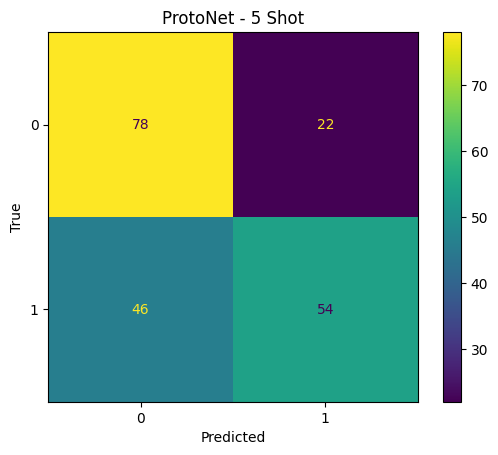

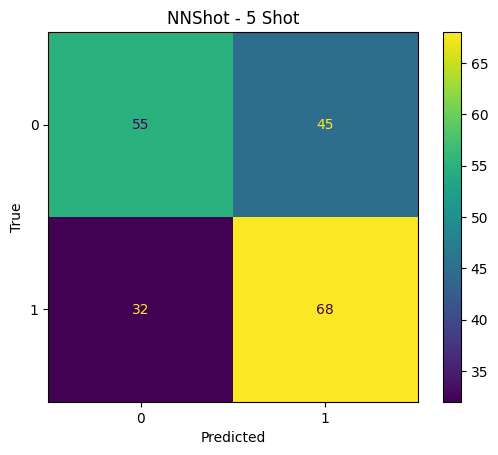

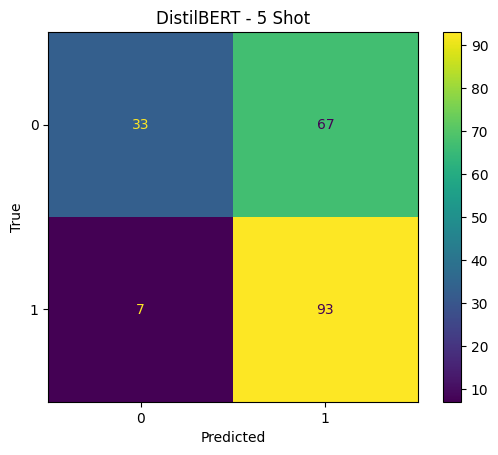

In [ ]:
plot_confusion(query_df['label'].tolist(), proto_preds, title="ProtoNet - 5 Shot")
plot_confusion(query_df['label'].tolist(), nn_preds, title="NNShot - 5 Shot")
plot_confusion(test_dataset['labels'], outputs.predictions.argmax(axis=1), title="DistilBERT - 5 Shot")

In [ ]:
# total parameters in the model
total_params = sum(p.numel() for p in model.parameters())
print(f"DistilBERT Params: {total_params / 1e6:.2f}M")

DistilBERT Params: 22.71M


In [ ]:
# Seperate into two different dataframes
df_imdb = df[df['domain'] == 'IMDB'].reset_index(drop=True)
df_yelp = df[df['domain'] == 'Yelp'].reset_index(drop=True)

In [ ]:
# Accuracy before yelp
support_imdb, query_imdb = sample_episode(df_imdb, n_shot=5)

proto = compute_prototypes(support_imdb)
proto_preds_imdb_before = predict_protonet(query_imdb, proto)
acc_imdb_before = evaluate_accuracy(proto_preds_imdb_before, query_imdb['label'].tolist())

print(f"IMDB Accuracy BEFORE Yelp: {acc_imdb_before:.4f}")

IMDB Accuracy BEFORE Yelp: 0.5850


In [ ]:
#Accuracy after Yelp
support_yelp, query_yelp = sample_episode(df_yelp, n_shot=5)

proto = compute_prototypes(support_yelp)
proto_preds_yelp = predict_protonet(query_yelp, proto)
acc_yelp = evaluate_accuracy(proto_preds_yelp, query_yelp['label'].tolist())

print(f"Yelp Accuracy (new task): {acc_yelp:.4f}")

Yelp Accuracy (new task): 0.7150


In [ ]:
proto_preds_imdb_after = predict_protonet(query_imdb, proto)
acc_imdb_after = evaluate_accuracy(proto_preds_imdb_after, query_imdb['label'].tolist())

print(f"IMDB Accuracy AFTER Yelp: {acc_imdb_after:.4f}")

IMDB Accuracy AFTER Yelp: 0.5150


In [ ]:
forgetting = acc_imdb_before - acc_imdb_after
print(f"Forgetting Rate on IMDB: {forgetting:.4f}")

Forgetting Rate on IMDB: 0.0700


In [ ]:
#Accuracy before/after YELP
nn_preds_imdb_before = predict_nnshot(query_imdb, support_imdb)
acc_nn_imdb_before = evaluate_accuracy(nn_preds_imdb_before, query_imdb['label'].tolist())

nn_preds_yelp = predict_nnshot(query_yelp, support_yelp)
acc_nn_yelp = evaluate_accuracy(nn_preds_yelp, query_yelp['label'].tolist())

nn_preds_imdb_after = predict_nnshot(query_imdb, support_yelp)  # support changed
acc_nn_imdb_after = evaluate_accuracy(nn_preds_imdb_after, query_imdb['label'].tolist())

forgetting = acc_nn_imdb_before - acc_nn_imdb_after

print(f"NNShot Accuracy BEFORE Yelp: {acc_nn_imdb_before:.4f}")
print(f"NNShot Accuracy AFTER Yelp: {acc_nn_imdb_after:.4f}")
print(f"Forgetting Rate on IMDB: {forgetting:.4f}")

NNShot Accuracy BEFORE Yelp: 0.5850
NNShot Accuracy AFTER Yelp: 0.5100
Forgetting Rate on IMDB: 0.0750


In [ ]:
df_imdb = df[df['domain'] == 'IMDB'].reset_index(drop=True)
df_yelp = df[df['domain'] == 'Yelp'].reset_index(drop=True)
support_imdb, query_imdb = sample_episode(df_imdb, n_shot=10)
support_yelp, query_yelp = sample_episode(df_yelp, n_shot=10)

In [ ]:
support_imdb[['text', 'label']].to_csv("train_imdb.csv", index=False)
query_imdb[['text', 'label']].to_csv("test_imdb.csv", index=False)

support_yelp[['text', 'label']].to_csv("train_yelp.csv", index=False)
query_yelp[['text', 'label']].to_csv("test_yelp.csv", index=False)

In [ ]:
train_df = pd.read_csv("train_imdb.csv")
test_df = pd.read_csv("test_imdb.csv")

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_dataset(df):
    dataset = Dataset.from_pandas(df)
    dataset = dataset.map(lambda x: tokenizer(x["text"], padding="max_length", truncation=True, max_length=128), batched=True)
    dataset = dataset.rename_column("label", "labels")
    dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
    return dataset

In [ ]:
def get_trainer(model, train_dataset, test_dataset):
    from transformers import Trainer, TrainingArguments

    training_args = TrainingArguments(
        output_dir="./results",
        training_epochs=5,
        per_device_train_batch_size=4,
        per_device_eval_batch_size=16,
        learning_rate=2e-5,
        logging_steps=1,
        save_strategy="no",
        report_to="none"
    )

    def compute_metrics(eval_pred):
        import numpy as np
        from sklearn.metrics import accuracy_score

        logits, labels = eval_pred
        preds = np.argmax(logits, axis=1)
        return {"accuracy": accuracy_score(labels, preds)}

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics
    )

    return trainer

In [ ]:
train_df = pd.read_csv("train_imdb.csv")
test_df = pd.read_csv("test_imdb.csv")

train_dataset = tokenize_dataset(train_df)
test_dataset = tokenize_dataset(test_df)
trainer = get_trainer(model, train_dataset, test_dataset)
trainer.train()
metrics = trainer.evaluate()
print(metrics)
#print(f"DistilBERT Accuracy BEFORE Yelp: {acc_before:.4f}")


Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Step,Training Loss
1,0.489000
2,0.558100
3,0.599200
4,0.520100
5,0.529400
6,0.505500
7,0.483000
8,0.389700
9,0.397100
10,0.499500


{'eval_loss': 0.6583759784698486, 'eval_accuracy': 0.565, 'eval_runtime': 0.657, 'eval_samples_per_second': 304.425, 'eval_steps_per_second': 19.788, 'epoch': 5.0}


In [ ]:
train_df = pd.read_csv("train_yelp.csv")
test_df = pd.read_csv("test_yelp.csv")

train_dataset = tokenize_dataset(train_df)
test_dataset = tokenize_dataset(test_df)
trainer = get_trainer(model, train_dataset, test_dataset)
trainer.train()
metrics = trainer.evaluate()
print(metrics)
#print(f"DistilBERT Accuracy BEFORE Yelp: {acc_before:.4f}")


Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Step,Training Loss
1,0.678900
2,0.862300
3,0.771900
4,0.653700
5,0.692000
6,0.600400
7,0.619600
8,0.574600
9,0.577800
10,0.714200


{'eval_loss': 0.5711351633071899, 'eval_accuracy': 0.765, 'eval_runtime': 0.6852, 'eval_samples_per_second': 291.894, 'eval_steps_per_second': 18.973, 'epoch': 5.0}


In [ ]:
from random import seed

seed(42)
torch.manual_seed(42)

In [ ]:
def sample_episode(df, n_shot, n_query , random_state):
    support = df.groupby("label").sample(n=n_shot, random_state=random_state)
    query   = df.drop(support.index).groupby("label").sample(n=n_query, random_state=None)
    return support.reset_index(drop=True), query.reset_index(drop=True)


#Baseline LSTM benchmark

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
#LSTM model
class BestLSTMClassifier(nn.Module):
    def __init__(self, input_dim=384, hidden_dim=256, num_layers=2, output_dim=2, dropout=0.5, bidirectional=True):
        super(BestLSTMClassifier, self).__init__()
        self.bidirectional = bidirectional

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers,
                            dropout=dropout, batch_first=True, bidirectional=bidirectional)
        self.dropout = nn.Dropout(dropout)

        fc_input_dim = hidden_dim * 2 if bidirectional else hidden_dim
        self.fc = nn.Linear(fc_input_dim, output_dim)

    def forward(self, x):

        x = x.unsqueeze(1)

        lstm_out, (hn, _) = self.lstm(x)

        if self.bidirectional:
            last_hidden = torch.cat((hn[-2], hn[-1]), dim=1)
        else:
            last_hidden = hn[-1]
        out = self.dropout(last_hidden)
        logits = self.fc(out)
        return logits

In [ ]:
model = BestLSTMClassifier(input_dim=384, hidden_dim=256, num_layers=2, output_dim=2, dropout=0.5, bidirectional=True).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# Training parameters
num_epochs = 50

# Training loop
model.train()
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_support)
    loss = criterion(outputs, y_support)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {loss.item():.4f}")

# Evaluation on query set
model.eval()
with torch.no_grad():
    query_outputs = model(X_query)
    predicted_labels = query_outputs.argmax(dim=1)
    accuracy = (predicted_labels == y_query).float().mean().item()

print(f"\nBest LSTM (without memory) Accuracy on Query Set: {accuracy:.4f}")

Epoch [10/50] | Loss: 0.6593
Epoch [20/50] | Loss: 0.4650
Epoch [30/50] | Loss: 0.0796
Epoch [40/50] | Loss: 0.0020
Epoch [50/50] | Loss: 0.0002

Best LSTM (without memory) Accuracy on Query Set: 0.6775


# LSTM With Memory

In [ ]:
#LSTM with memory augmentation
class MemoryAugmentedLSTM(nn.Module):
    def __init__(self, input_dim=384, hidden_dim=256, output_dim=2):
        super(MemoryAugmentedLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.key_proj = nn.Linear(hidden_dim * 2, input_dim)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2 + output_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, output_dim)
        )

    def forward(self, query_x, memory_keys, memory_values):
        lstm_out, (h_n, _) = self.lstm(query_x.unsqueeze(1))
        h_final = torch.cat((h_n[-2], h_n[-1]), dim=1)
        query_key = self.key_proj(h_final)
        attn_scores = torch.matmul(query_key, memory_keys.T)
        attn_weights = torch.softmax(attn_scores, dim=1)
        memory_readout = torch.matmul(attn_weights, memory_values)
        combined = torch.cat([h_final, memory_readout], dim=1)
        logits = self.classifier(combined)
        return logits

In [ ]:
def build_memory(support_embeddings, support_labels, num_classes=2):
    memory_keys = support_embeddings
    memory_values = F.one_hot(support_labels, num_classes=num_classes).float()
    return memory_keys, memory_values

In [ ]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes=2, smoothing=0.1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.log_softmax = nn.LogSoftmax(dim=-1)

    def forward(self, x, target):
        logprobs = self.log_softmax(x)
        true_dist = torch.zeros_like(logprobs)
        true_dist.fill_(self.smoothing / (self.cls - 1))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * logprobs, dim=-1))

In [ ]:
from torch.utils.data import DataLoader

def meta_train(
    model, optimizer, criterion,
    df, n_support=5, n_query=100,
    episodes_per_epoch=100, epochs=20
):
    model.train()
    for ep in range(epochs):
        total_loss = 0
        for episode_idx in range(episodes_per_epoch):
            # Sample a new episode
            sup_df, qry_df = sample_episode(df, n_shot=n_support, n_query=n_query)

            # Stack embeddings Tensors
            X_sup, y_sup = stack_embeddings(sup_df)
            X_qry, y_qry = stack_embeddings(qry_df)

            X_sup, y_sup = X_sup.to(device), y_sup.to(device)
            X_qry, y_qry = X_qry.to(device), y_qry.to(device)

            # Build memory from support
            mem_keys, mem_vals = build_memory(X_sup, y_sup, num_classes=2)
            mem_keys, mem_vals = mem_keys.to(device), mem_vals.to(device)

            # Forward on query and compute loss
            optimizer.zero_grad()
            logits = model(X_qry, mem_keys, mem_vals)
            loss = criterion(logits, y_qry)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / episodes_per_epoch
        print(f"Epoch {ep+1}/{epochs} — avg episode loss: {avg_loss:.4f}")

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#  Instantiate
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model     = MemoryAugmentedLSTM().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

def sample_episode(df, n_shot, n_query):
    support = df.groupby("label").sample(n=n_shot, random_state=None)
    query   = df.drop(support.index).groupby("label").sample(n=n_query, random_state=None)
    return support.reset_index(drop=True), query.reset_index(drop=True)

#  Run meta-training
meta_train(
    model, optimizer, criterion,
    df=df,
    n_support=10, n_query=100,
    episodes_per_epoch=200,
    epochs=30
)

sup_df, qry_df = sample_episode(df, n_shot=5, n_query=200)
X_sup, y_sup = stack_embeddings(sup_df)
X_qry, y_qry = stack_embeddings(qry_df)
mem_keys, mem_vals = build_memory(X_sup.to(device), y_sup.to(device), 2)

model.eval()
with torch.no_grad():
    logits = model(X_qry.to(device), mem_keys, mem_vals)
    preds = logits.argmax(dim=1)
    acc   = (preds.cpu() == y_qry).float().mean().item()
print(f"Meta-Trained Memory-LSTM 5-shot Accuracy: {acc:.4f}")



Epoch 1/30 — avg episode loss: 0.3882
Epoch 2/30 — avg episode loss: 0.3278
Epoch 3/30 — avg episode loss: 0.3242
Epoch 4/30 — avg episode loss: 0.3199
Epoch 5/30 — avg episode loss: 0.3125
Epoch 6/30 — avg episode loss: 0.3096
Epoch 7/30 — avg episode loss: 0.3030
Epoch 8/30 — avg episode loss: 0.2996
Epoch 9/30 — avg episode loss: 0.2992
Epoch 10/30 — avg episode loss: 0.2942
Epoch 11/30 — avg episode loss: 0.2937
Epoch 12/30 — avg episode loss: 0.2857
Epoch 13/30 — avg episode loss: 0.2829
Epoch 14/30 — avg episode loss: 0.2866
Epoch 15/30 — avg episode loss: 0.2773
Epoch 16/30 — avg episode loss: 0.2760
Epoch 17/30 — avg episode loss: 0.2800
Epoch 18/30 — avg episode loss: 0.2767
Epoch 19/30 — avg episode loss: 0.2677
Epoch 20/30 — avg episode loss: 0.2740
Epoch 21/30 — avg episode loss: 0.2668
Epoch 22/30 — avg episode loss: 0.2648
Epoch 23/30 — avg episode loss: 0.2619
Epoch 24/30 — avg episode loss: 0.2596
Epoch 25/30 — avg episode loss: 0.2573
Epoch 26/30 — avg episode loss: 0.

In [ ]:
torch.save(model.state_dict(), "mann_model_weights.pth")

In [ ]:
# Instantiate
Mann_model     = MemoryAugmentedLSTM().to(device)
optimizer = torch.optim.Adam(Mann_model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

def sample_episode(df, n_shot, n_query):
    support = df.groupby("label").sample(n=n_shot, random_state=None)
    query   = df.drop(support.index).groupby("label").sample(n=n_query, random_state=None)
    return support.reset_index(drop=True), query.reset_index(drop=True)


meta_train(
    Mann_model, optimizer, criterion,
    df=df,
    n_support=10, n_query=100,
    episodes_per_epoch=200,
    epochs=30
)

sup_df, qry_df = sample_episode(df, n_shot=5, n_query=200)
X_sup, y_sup = stack_embeddings(sup_df)
X_qry, y_qry = stack_embeddings(qry_df)
mem_keys, mem_vals = build_memory(X_sup.to(device), y_sup.to(device), 2)

model.eval()
with torch.no_grad():
    logits = Mann_model(X_qry.to(device), mem_keys, mem_vals)
    preds = logits.argmax(dim=1)
    acc   = (preds.cpu() == y_qry).float().mean().item()
print(f"Meta-Trained Memory-LSTM 5-shot Accuracy: {acc:.4f}")

Epoch 1/30 — avg episode loss: 0.3848
Epoch 2/30 — avg episode loss: 0.3342
Epoch 3/30 — avg episode loss: 0.3273
Epoch 4/30 — avg episode loss: 0.3157
Epoch 5/30 — avg episode loss: 0.3049
Epoch 6/30 — avg episode loss: 0.3097
Epoch 7/30 — avg episode loss: 0.3020
Epoch 8/30 — avg episode loss: 0.2971
Epoch 9/30 — avg episode loss: 0.3028
Epoch 10/30 — avg episode loss: 0.2946
Epoch 11/30 — avg episode loss: 0.2971
Epoch 12/30 — avg episode loss: 0.2879
Epoch 13/30 — avg episode loss: 0.2896
Epoch 14/30 — avg episode loss: 0.2836
Epoch 15/30 — avg episode loss: 0.2847
Epoch 16/30 — avg episode loss: 0.2777
Epoch 17/30 — avg episode loss: 0.2796
Epoch 18/30 — avg episode loss: 0.2804
Epoch 19/30 — avg episode loss: 0.2714
Epoch 20/30 — avg episode loss: 0.2733
Epoch 21/30 — avg episode loss: 0.2720
Epoch 22/30 — avg episode loss: 0.2701
Epoch 23/30 — avg episode loss: 0.2634
Epoch 24/30 — avg episode loss: 0.2567
Epoch 25/30 — avg episode loss: 0.2622
Epoch 26/30 — avg episode loss: 0.

In [ ]:
import time, torch, torch.nn as nn
from torch.optim import Adam


print(f"Memory-LSTM Params: {sum(p.numel() for p in Mann_model.parameters() if p.requires_grad)/1e6:.2f}M")

# Prepare support and query sets
sup_df, qry_df = sample_episode(df, n_shot=5, n_query=200)
X_sup, y_sup = stack_embeddings(sup_df)
X_qry, y_qry = stack_embeddings(qry_df)
X_sup, y_sup = X_sup.to(device), y_sup.to(device)
X_qry, y_qry = X_qry.to(device), y_qry.to(device)
mem_keys, mem_vals = build_memory(X_sup, y_sup, num_classes=2)
mem_keys, mem_vals = mem_keys.to(device), mem_vals.to(device)

# small query batch to avoid initial latency
_ = Mann_model(X_qry[:10], mem_keys, mem_vals)

start = time.time()
with torch.no_grad():
    _ = Mann_model(X_qry, mem_keys, mem_vals)
total = time.time() - start
print(f" Total inference: {total:.4f}s | Avg/sample: {total/len(X_qry):.6f}s")


optimizer = Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# Training the Memory-LSTM model on the IMDB data
meta_train(Mann_model, optimizer, criterion,
           df=df[df.domain=='IMDB'],
           n_support=5, n_query=100,
           episodes_per_epoch=200, epochs=10)

sup_I, qry_I = sample_episode(df[df.domain=='IMDB'], 5, 200)
X_I_sup, y_I_sup = stack_embeddings(sup_I); X_I_qry, y_I_qry = stack_embeddings(qry_I)
mem_kI, mem_vI = build_memory(X_I_sup.to(device), y_I_sup.to(device), 2)
model.eval()
with torch.no_grad():
    logits_before = Mann_model(X_I_qry.to(device), mem_kI, mem_vI)
acc_before = (logits_before.argmax(1).cpu()==y_I_qry).float().mean().item()
print(f" IMDB before: {acc_before:.4f}")

# Training the Memory-LSTM model on the Yelp data
meta_train(Mann_model, optimizer, criterion,
           df=df[df.domain=='Yelp'],
           n_support=5, n_query=100,
           episodes_per_epoch=200, epochs=10)

Mann_model.eval()
with torch.no_grad():
    logits_after = Mann_model(X_I_qry.to(device), mem_kI, mem_vI)
acc_after = (logits_after.argmax(1).cpu()==y_I_qry).float().mean().item()
print(f" IMDB after: {acc_after:.4f}")

print(f"Forgetting Rate: {acc_before - acc_after:.4f}")

Memory-LSTM Params: 1.68M
 Total inference: 0.0016s | Avg/sample: 0.000004s
Epoch 1/10 — avg episode loss: 0.3622
Epoch 2/10 — avg episode loss: 0.3601
Epoch 3/10 — avg episode loss: 0.3658
Epoch 4/10 — avg episode loss: 0.3660
Epoch 5/10 — avg episode loss: 0.3635
Epoch 6/10 — avg episode loss: 0.3699
Epoch 7/10 — avg episode loss: 0.3658
Epoch 8/10 — avg episode loss: 0.3666
Epoch 9/10 — avg episode loss: 0.3625
Epoch 10/10 — avg episode loss: 0.3673
 IMDB before: 0.8100
Epoch 1/10 — avg episode loss: 0.1650
Epoch 2/10 — avg episode loss: 0.1661
Epoch 3/10 — avg episode loss: 0.1694
Epoch 4/10 — avg episode loss: 0.1673
Epoch 5/10 — avg episode loss: 0.1675
Epoch 6/10 — avg episode loss: 0.1634
Epoch 7/10 — avg episode loss: 0.1688
Epoch 8/10 — avg episode loss: 0.1643
Epoch 9/10 — avg episode loss: 0.1674
Epoch 10/10 — avg episode loss: 0.1700


RuntimeError: Expected tensor for argument #1 'indices' to have one of the following scalar types: Long, Int; but got torch.cuda.FloatTensor instead (while checking arguments for embedding)

In [ ]:
Mann_model.eval()
with torch.no_grad():
    logits_after = Mann_model(X_I_qry.to(device), mem_kI, mem_vI)
acc_after = (logits_after.argmax(1).cpu()==y_I_qry).float().mean().item()
print(f" IMDB after: {acc_after:.4f}")

print(f"Forgetting Rate: {acc_before - acc_after:.4f}")

 IMDB after: 0.8275
Forgetting Rate: -0.0175


In [ ]:
#Spliting the data and leaving out IMDB
heldout   = "IMDB"
train_df  = df[df.domain != heldout].reset_index(drop=True)
test_df   = df[df.domain == heldout].reset_index(drop=True)

model     = MemoryAugmentedLSTM(input_dim=384, hidden_dim=256, output_dim=2).to(device)
optimizer = Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

#Training on support and query
meta_train(
    model, optimizer, criterion,
    df=train_df,
    n_support=5,
    n_query=100,
    episodes_per_epoch=200,
    epochs=30
)

sup_df, qry_df = sample_episode(test_df, n_shot=5, n_query=200)

# converting data into embeddings
X_sup, y_sup = stack_embeddings(sup_df)
X_qry, y_qry = stack_embeddings(qry_df)
X_sup, y_sup = X_sup.to(device), y_sup.to(device)
X_qry, y_qry = X_qry.to(device), y_qry.to(device)

# building external memory using from support set
mem_keys, mem_vals = build_memory(X_sup, y_sup, num_classes=2)
mem_keys, mem_vals = mem_keys.to(device), mem_vals.to(device)

model.eval()
with torch.no_grad():
    logits = model(X_qry, mem_keys, mem_vals)
    preds  = logits.argmax(dim=1)
    ood_acc = (preds.cpu() == y_qry.cpu()).float().mean().item()

print(f"Meta-Trained Memory-LSTM OOD 5-Shot Accuracy on IMDB: {ood_acc:.4f}")

Epoch 1/30 — avg episode loss: 0.3415
Epoch 2/30 — avg episode loss: 0.2865
Epoch 3/30 — avg episode loss: 0.2750
Epoch 4/30 — avg episode loss: 0.2753
Epoch 5/30 — avg episode loss: 0.2710
Epoch 6/30 — avg episode loss: 0.2692
Epoch 7/30 — avg episode loss: 0.2663
Epoch 8/30 — avg episode loss: 0.2610
Epoch 9/30 — avg episode loss: 0.2566
Epoch 10/30 — avg episode loss: 0.2549
Epoch 11/30 — avg episode loss: 0.2537
Epoch 12/30 — avg episode loss: 0.2508
Epoch 13/30 — avg episode loss: 0.2454
Epoch 14/30 — avg episode loss: 0.2421
Epoch 15/30 — avg episode loss: 0.2358
Epoch 16/30 — avg episode loss: 0.2343
Epoch 17/30 — avg episode loss: 0.2299
Epoch 18/30 — avg episode loss: 0.2289
Epoch 19/30 — avg episode loss: 0.2223
Epoch 20/30 — avg episode loss: 0.2238
Epoch 21/30 — avg episode loss: 0.2199
Epoch 22/30 — avg episode loss: 0.2158
Epoch 23/30 — avg episode loss: 0.2118
Epoch 24/30 — avg episode loss: 0.2060
Epoch 25/30 — avg episode loss: 0.2022
Epoch 26/30 — avg episode loss: 0.

In [ ]:
heldout  = "IMDB"
test_df  = df[df.domain == heldout].reset_index(drop=True)

sup_df, qry_df = sample_episode(test_df, n_shot=5, n_query=200)

nn_preds = predict_nnshot(qry_df, sup_df)

acc_nn_ood = evaluate_accuracy(nn_preds, qry_df['label'].tolist())

print(f"NNShot OOD 5-Shot Accuracy on IMDB: {acc_nn_ood:.4f}")

NNShot OOD 5-Shot Accuracy on IMDB: 0.5500


In [ ]:
heldout = "IMDB"
test_df = df[df.domain == heldout].reset_index(drop=True)

sup_df, qry_df = sample_episode(test_df, n_shot=5, n_query=200)

protos = compute_prototypes(sup_df)

proto_preds = predict_protonet(qry_df, protos)

proto_ood_acc = evaluate_accuracy(proto_preds, qry_df['label'].tolist())

print(f" ProtoNet OOD 5-Shot Accuracy on IMDB: {proto_ood_acc:.4f}")

 ProtoNet OOD 5-Shot Accuracy on IMDB: 0.5150


In [ ]:
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score

heldout  = "IMDB"
train_df = df[df.domain != heldout].reset_index(drop=True)
test_df  = df[df.domain == heldout].reset_index(drop=True)

sup_train, _ = sample_episode(train_df, n_shot=5, n_query=200)
_, qry_test  = sample_episode(test_df,  n_shot=5, n_query=200)

sup_train[['text','label']].to_csv("ood_train.csv", index=False)
qry_test[['text','label']].to_csv("ood_test.csv",  index=False)

train_ds = Dataset.from_pandas(pd.read_csv("ood_train.csv"))
test_ds  = Dataset.from_pandas(pd.read_csv("ood_test.csv"))

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
def tokenize_fn(ex):
    return tokenizer(ex["text"], padding="max_length", truncation=True, max_length=128)

train_ds = train_ds.map(tokenize_fn, batched=True)
test_ds  = test_ds.map(tokenize_fn,  batched=True)

train_ds = train_ds.rename_column("label", "labels")
test_ds  = test_ds.rename_column("label",  "labels")

train_ds.set_format("torch", columns=["input_ids","attention_mask","labels"])
test_ds.set_format( "torch", columns=["input_ids","attention_mask","labels"])

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2
)

training_args = TrainingArguments(
    output_dir="./results",
    training_epochs=5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    logging_steps=1,
    save_strategy="no",
    report_to="none"

)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds
)

trainer.train()

predictions = trainer.predict(test_ds)
logits     = predictions.predictions
labels     = predictions.label_ids

preds = logits.argmax(axis=1)
ood_acc = accuracy_score(labels, preds)

print(f"DistilBERT OOD 5-Shot Accuracy on IMDB: {ood_acc:.4f}")

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
1,0.682600
2,0.687600
3,0.652700
4,0.679600
5,0.651500
6,0.631100
7,0.636100
8,0.642100
9,0.656600
10,0.652800


DistilBERT OOD 5-Shot Accuracy on IMDB: 0.5525


In [ ]:
import random
import numpy as np
import torch
import torch.nn as nn
from scipy.stats import ttest_rel

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

def sample_episode(df, n_shot, n_query, random_state=None):
    support = df.groupby("label").sample(n=n_shot, random_state=random_state)
    query   = df.drop(support.index).groupby("label").sample(n=n_query, random_state=random_state)
    return support.reset_index(drop=True), query.reset_index(drop=True)

def evaluate_ood_mem(model, test_df, episodes=20):
    accs = []
    for i in range(episodes):
        sup, qry = sample_episode(test_df, 5, 200, random_state=i)
        X_sup, y_sup = stack_embeddings(sup)
        X_qry, y_qry = stack_embeddings(qry)
        X_sup, y_sup = X_sup.to(device), y_sup.to(device)
        X_qry, y_qry = X_qry.to(device), y_qry.to(device)
        mem_k, mem_v = build_memory(X_sup, y_sup, num_classes=2)
        mem_k, mem_v = mem_k.to(device), mem_v.to(device)
        model.eval()
        with torch.no_grad():
            preds = model(X_qry, mem_k, mem_v).argmax(dim=1).cpu().numpy()
        accs.append((preds == y_qry.cpu().numpy()).mean())
    return np.array(accs)

def evaluate_ood_proto(test_df, episodes=20):
    accs = []
    for i in range(episodes):
        sup, qry = sample_episode(test_df, 5, 200, random_state=i)
        protos = compute_prototypes(sup)
        preds  = predict_protonet(qry, protos)
        accs.append(evaluate_accuracy(preds, qry['label'].tolist()))
    return np.array(accs)

train_df = df[df.domain != 'IMDB'].reset_index(drop=True)
test_df  = df[df.domain == 'IMDB'].reset_index(drop=True)

model_ood  = MemoryAugmentedLSTM().to(device)
opt_ood    = torch.optim.Adam(model_ood.parameters(), lr=1e-3)
crit       = nn.CrossEntropyLoss()

meta_train(
    model_ood, opt_ood, crit,
    df=train_df,
    n_support=5, n_query=100,
    episodes_per_epoch=200,
    epochs=30
)

accs_mem_ood   = evaluate_ood_mem(model_ood, test_df, episodes=20)
accs_proto_ood = evaluate_ood_proto(test_df, episodes=20)

print(f"Memory-LSTM OOD IMDB mean±std: {accs_mem_ood.mean():.4f} ± {accs_mem_ood.std():.4f}")
print(f"ProtoNet   OOD IMDB mean±std: {accs_proto_ood.mean():.4f} ± {accs_proto_ood.std():.4f}")
t_stat, p_val = ttest_rel(accs_mem_ood, accs_proto_ood)
print(f"Paired t-test Memory vs ProtoNet: t={t_stat:.4f}, p={p_val:.4f}")

Epoch 1/30 — avg episode loss: 0.3448
Epoch 2/30 — avg episode loss: 0.2912
Epoch 3/30 — avg episode loss: 0.2881
Epoch 4/30 — avg episode loss: 0.2810
Epoch 5/30 — avg episode loss: 0.2687
Epoch 6/30 — avg episode loss: 0.2742
Epoch 7/30 — avg episode loss: 0.2607
Epoch 8/30 — avg episode loss: 0.2611
Epoch 9/30 — avg episode loss: 0.2583
Epoch 10/30 — avg episode loss: 0.2560
Epoch 11/30 — avg episode loss: 0.2532
Epoch 12/30 — avg episode loss: 0.2504
Epoch 13/30 — avg episode loss: 0.2463
Epoch 14/30 — avg episode loss: 0.2389
Epoch 15/30 — avg episode loss: 0.2364
Epoch 16/30 — avg episode loss: 0.2310
Epoch 17/30 — avg episode loss: 0.2300
Epoch 18/30 — avg episode loss: 0.2309
Epoch 19/30 — avg episode loss: 0.2187
Epoch 20/30 — avg episode loss: 0.2142
Epoch 21/30 — avg episode loss: 0.2178
Epoch 22/30 — avg episode loss: 0.2129
Epoch 23/30 — avg episode loss: 0.2117
Epoch 24/30 — avg episode loss: 0.2102
Epoch 25/30 — avg episode loss: 0.2048
Epoch 26/30 — avg episode loss: 0.

Epoch 1/30 — avg episode loss: 0.4487
Epoch 2/30 — avg episode loss: 0.4054
Epoch 3/30 — avg episode loss: 0.3952
Epoch 4/30 — avg episode loss: 0.3888
Epoch 5/30 — avg episode loss: 0.3862
Epoch 6/30 — avg episode loss: 0.3737
Epoch 7/30 — avg episode loss: 0.3703
Epoch 8/30 — avg episode loss: 0.3665
Epoch 9/30 — avg episode loss: 0.3625
Epoch 10/30 — avg episode loss: 0.3612
Epoch 11/30 — avg episode loss: 0.3514
Epoch 12/30 — avg episode loss: 0.3448
Epoch 13/30 — avg episode loss: 0.3420
Epoch 14/30 — avg episode loss: 0.3343
Epoch 15/30 — avg episode loss: 0.3292
Epoch 16/30 — avg episode loss: 0.3196
Epoch 17/30 — avg episode loss: 0.3159
Epoch 18/30 — avg episode loss: 0.3067
Epoch 19/30 — avg episode loss: 0.3039
Epoch 20/30 — avg episode loss: 0.2977
Epoch 21/30 — avg episode loss: 0.2920
Epoch 22/30 — avg episode loss: 0.2851
Epoch 23/30 — avg episode loss: 0.2779
Epoch 24/30 — avg episode loss: 0.2705
Epoch 25/30 — avg episode loss: 0.2601
Epoch 26/30 — avg episode loss: 0.

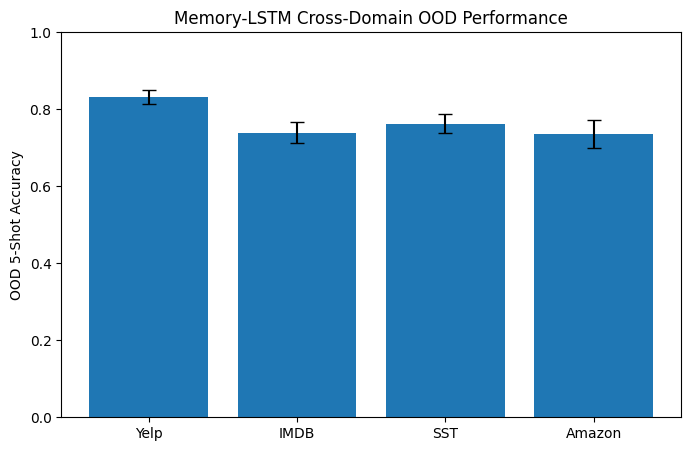

In [ ]:
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

def sample_episode(df, n_shot, n_query, random_state=None):
    support = df.groupby("label") \
                .sample(n=n_shot, random_state=random_state)
    remaining = df.drop(support.index)

    query   = remaining.groupby("label") \
                       .sample(n=n_query, replace=True, random_state=random_state)
    return support.reset_index(drop=True), query.reset_index(drop=True)

ood_results = {}
for dom in df.domain.unique():

    train_df = df[df.domain != dom].reset_index(drop=True)
    test_df  = df[df.domain == dom].reset_index(drop=True)

    mdl = MemoryAugmentedLSTM().to(device)
    opt = torch.optim.Adam(mdl.parameters(), lr=1e-3)
    crit = nn.CrossEntropyLoss()
    meta_train(
        mdl, opt, crit,
        df=train_df,
        n_support=5,
        n_query=100,
        episodes_per_epoch=200,
        epochs=30
    )

    accs = []
    for i in range(20):
        sup, qry = sample_episode(test_df, 5, 100, random_state=i)
        X_sup, y_sup = stack_embeddings(sup)
        X_qry, y_qry = stack_embeddings(qry)
        X_sup, y_sup = X_sup.to(device), y_sup.to(device)
        X_qry, y_qry = X_qry.to(device), y_qry.to(device)

        mem_k, mem_v = build_memory(X_sup, y_sup, num_classes=2)
        mem_k, mem_v = mem_k.to(device), mem_v.to(device)

        mdl.eval()
        with torch.no_grad():
            preds = mdl(X_qry, mem_k, mem_v).argmax(dim=1).cpu().numpy()
        accs.append((preds == y_qry.cpu().numpy()).mean())

    ood_results[dom] = (np.mean(accs), np.std(accs))

domains = list(ood_results.keys())
means   = [ood_results[d][0] for d in domains]
stds    = [ood_results[d][1] for d in domains]

plt.figure(figsize=(8,5))
plt.bar(domains, means, yerr=stds, capsize=5)
plt.ylim(0,1)
plt.ylabel("OOD 5-Shot Accuracy")
plt.title("Memory-LSTM Cross-Domain OOD Performance")
plt.show()

In [ ]:
#Picking some samples from each label
def sample_episode(df, n_shot, n_query, random_state=None):
    support = df.groupby("label") \
                .sample(n=n_shot, random_state=random_state)
    remaining = df.drop(support.index)
    query   = remaining.groupby("label") \
                       .sample(n=n_query, replace=True, random_state=random_state)
    return support.reset_index(drop=True), query.reset_index(drop=True)

#Evaluating without model
def evaluate_ood_nomem(model, test_df, episodes=20):

    accs = []
    for i in range(episodes):
        sup, qry = sample_episode(test_df, 5, 100, random_state=i)
        _, y_qry = stack_embeddings(qry)
        X_qry, y_qry = stack_embeddings(qry)
        X_qry, y_qry = X_qry.to(device), y_qry.to(device)

        model.eval()
        with torch.no_grad():
            preds = model(X_qry).argmax(dim=1).cpu().numpy()
        accs.append((preds == y_qry.cpu().numpy()).mean())
    return np.array(accs)

#Evaluating the prototype-based model
def evaluate_ood_proto(test_df, episodes=20):
    accs = []
    for i in range(episodes):
        sup, qry = sample_episode(test_df, 5, 200, random_state=i)
        protos = compute_prototypes(sup)
        preds  = predict_protonet(qry, protos)
        accs.append(evaluate_accuracy(preds, qry['label'].tolist()))
    return np.array(accs)




In [ ]:
# Training the LSTM model without memory
def meta_train_no_mem(
    model, optimizer, criterion,
    df, n_support=5, n_query=100,
    episodes_per_epoch=100, epochs=20
):
    model.train()
    for ep in range(1, epochs+1):
        total_loss = 0.0
        for _ in range(episodes_per_epoch):

            sup_df, qry_df = sample_episode(df, n_shot=n_support, n_query=n_query)

            X_qry, y_qry = stack_embeddings(qry_df)
            X_qry, y_qry = X_qry.to(device), y_qry.to(device)

            optimizer.zero_grad()
            logits = model(X_qry)
            loss   = criterion(logits, y_qry)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"NoMem Epoch {ep}/{epochs} — avg loss: {total_loss/episodes_per_epoch:.4f}")

In [ ]:
# Testing the memory-augmented LSTM model
def evaluate_ood_mem(model, test_df, episodes=20):
    accs = []
    for i in range(episodes):
        sup, qry = sample_episode(test_df, 5, 200, random_state=i)
        X_sup, y_sup = stack_embeddings(sup)
        X_qry, y_qry = stack_embeddings(qry)
        X_sup, y_sup = X_sup.to(device), y_sup.to(device)
        X_qry, y_qry = X_qry.to(device), y_qry.to(device)
        mem_k, mem_v = build_memory(X_sup, y_sup, num_classes=2)
        mem_k, mem_v = mem_k.to(device), mem_v.to(device)
        model.eval()
        with torch.no_grad():
            preds = model(X_qry, mem_k, mem_v).argmax(dim=1).cpu().numpy()
        accs.append((preds == y_qry.cpu().numpy()).mean())
    return np.array(accs)

def evaluate_ood_proto(test_df, episodes=20):
    accs = []
    for i in range(episodes):
        sup, qry = sample_episode(test_df, 5, 200, random_state=i)
        protos = compute_prototypes(sup)
        preds  = predict_protonet(qry, protos)
        accs.append(evaluate_accuracy(preds, qry['label'].tolist()))
    return np.array(accs)

Epoch 1/15 — avg episode loss: 0.4860
Epoch 2/15 — avg episode loss: 0.4113
Epoch 3/15 — avg episode loss: 0.4047
Epoch 4/15 — avg episode loss: 0.4110
Epoch 5/15 — avg episode loss: 0.3997
Epoch 6/15 — avg episode loss: 0.3968
Epoch 7/15 — avg episode loss: 0.3929
Epoch 8/15 — avg episode loss: 0.3892
Epoch 9/15 — avg episode loss: 0.3909
Epoch 10/15 — avg episode loss: 0.3836
Epoch 11/15 — avg episode loss: 0.3875
Epoch 12/15 — avg episode loss: 0.3827
Epoch 13/15 — avg episode loss: 0.3781
Epoch 14/15 — avg episode loss: 0.3752
Epoch 15/15 — avg episode loss: 0.3785
NoMem Epoch 1/15 — avg loss: 0.4902
NoMem Epoch 2/15 — avg loss: 0.4106
NoMem Epoch 3/15 — avg loss: 0.4009
NoMem Epoch 4/15 — avg loss: 0.4055
NoMem Epoch 5/15 — avg loss: 0.3991
NoMem Epoch 6/15 — avg loss: 0.3967
NoMem Epoch 7/15 — avg loss: 0.3939
NoMem Epoch 8/15 — avg loss: 0.3907
NoMem Epoch 9/15 — avg loss: 0.3913
NoMem Epoch 10/15 — avg loss: 0.3939
NoMem Epoch 11/15 — avg loss: 0.3809
NoMem Epoch 12/15 — avg lo

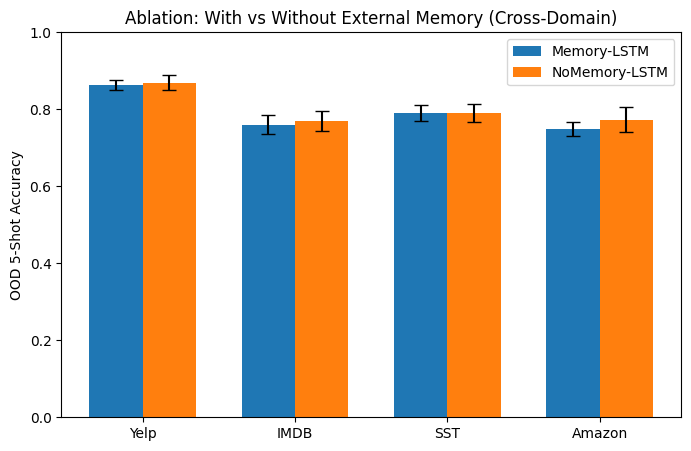

In [ ]:
domains = df.domain.unique()
mem_means, mem_stds = [], []
no_means,  no_stds  = [], []

for dom in domains:
    train_df = df[df.domain != dom].reset_index(drop=True)
    test_df  = df[df.domain == dom].reset_index(drop=True)

    # Meta-train Memory-LSTM
    mdl_mem = MemoryAugmentedLSTM().to(device)
    opt_mem = torch.optim.Adam(mdl_mem.parameters(), lr=1e-3)
    crit    = nn.CrossEntropyLoss()
    meta_train(mdl_mem, opt_mem, crit,
               df=train_df,
               n_support=5, n_query=100,
               episodes_per_epoch=100, epochs=15)
    accs_mem = evaluate_ood_mem(mdl_mem, test_df, episodes=10)
    mem_means.append(accs_mem.mean())
    mem_stds.append(accs_mem.std())

    # Meta-train NoMemory-LSTM
    mdl_nom = BestLSTMClassifier().to(device)
    opt_nom = torch.optim.Adam(mdl_nom.parameters(), lr=1e-3)
    crit_nom= nn.CrossEntropyLoss()
    meta_train_no_mem(mdl_nom, opt_nom, crit_nom,
                      df=train_df,
                      n_support=5, n_query=100,
                      episodes_per_epoch=100, epochs=15)
    accs_nom = evaluate_ood_nomem(mdl_nom, test_df, episodes=10)
    no_means.append(accs_nom.mean())
    no_stds.append(accs_nom.std())

x = np.arange(len(domains))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, mem_means, width, yerr=mem_stds, capsize=5, label='Memory-LSTM')
plt.bar(x + width/2, no_means,  width, yerr=no_stds,  capsize=5, label='NoMemory-LSTM')
plt.xticks(x, domains)
plt.ylabel("OOD 5-Shot Accuracy")
plt.title("Ablation: With vs Without External Memory (Cross-Domain)")
plt.ylim(0,1)
plt.legend()
plt.show()

In [ ]:
#LSTM Model
class MetaLSTM(nn.Module):
    def __init__(self, input_dim=384, hidden_dim=256, output_dim=2):
        super(MetaLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        lstm_out, (h_n, _) = self.lstm(x.unsqueeze(1))  # (batch, 1, input_dim)
        h_final = torch.cat((h_n[-2], h_n[-1]), dim=1)  # (batch, hidden_dim*2)
        return self.classifier(h_final)

In [ ]:
#Training the LSTM model
def meta_train_lstm(model, optimizer, criterion, df, n_support=5, n_query=100, episodes_per_epoch=100, epochs=20):
    model.train()
    for ep in range(epochs):
        total_loss = 0
        for _ in range(episodes_per_epoch):
            sup_df, qry_df = sample_episode(df, n_shot=n_support, n_query=n_query)

            X_sup, y_sup = stack_embeddings(sup_df)
            X_qry, y_qry = stack_embeddings(qry_df)

            X_sup, y_sup = X_sup.to(device), y_sup.to(device)
            X_qry, y_qry = X_qry.to(device), y_qry.to(device)

            optimizer.zero_grad()
            logits = model(X_sup)
            loss = criterion(logits, y_sup)
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                logits_qry = model(X_qry)
                qry_loss = criterion(logits_qry, y_qry)
                total_loss += qry_loss.item()

        print(f"Epoch {ep+1}/{epochs} — avg query loss: {total_loss / episodes_per_epoch:.4f}")

In [ ]:
def meta_train_lstm(model, optimizer, criterion, df, n_support=5, n_query=100, episodes_per_epoch=100, epochs=20):
    model.train()
    for ep in range(epochs):
        total_loss = 0
        for _ in range(episodes_per_epoch):
            sup_df, qry_df = sample_episode(df, n_shot=n_support, n_query=n_query)

            X_sup, y_sup = stack_embeddings(sup_df)
            X_qry, y_qry = stack_embeddings(qry_df)

            X_sup, y_sup = X_sup.to(device), y_sup.to(device)
            X_qry, y_qry = X_qry.to(device), y_qry.to(device)

            optimizer.zero_grad()
            logits = model(X_sup)
            loss = criterion(logits, y_sup)
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                logits_qry = model(X_qry)
                qry_loss = criterion(logits_qry, y_qry)
                total_loss += qry_loss.item()

        print(f"Epoch {ep+1}/{epochs} — avg query loss: {total_loss / episodes_per_epoch:.4f}")

In [ ]:
#Evaluating
def evaluate_lstm(model, df, n_support=5, n_query=200):
    model.eval()
    sup_df, qry_df = sample_episode(df, n_shot=n_support, n_query=n_query)
    X_sup, y_sup = stack_embeddings(sup_df)
    X_qry, y_qry = stack_embeddings(qry_df)

    with torch.no_grad():
        logits = model(X_qry.to(device))
        preds = logits.argmax(dim=1).cpu()
        acc = (preds == y_qry).float().mean().item()
    return acc

In [ ]:
# Instantiate model
imdb_df = df[df['domain'] == 'IMDB'].reset_index(drop=True)
yelp_df = df[df['domain'] == 'Yelp'].reset_index(drop=True)
meta_lstm = MetaLSTM().to(device)
optimizer = torch.optim.Adam(meta_lstm.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# Meta-train on IMDB
meta_train_lstm(meta_lstm, optimizer, criterion, imdb_df, epochs=20)

# Evaluate BEFORE training on new task
acc_before = evaluate_lstm(meta_lstm, imdb_df)

# Meta-train on Yelp
meta_train_lstm(meta_lstm, optimizer, criterion, yelp_df, epochs=10)

acc_after = evaluate_lstm(meta_lstm, imdb_df)

# Forgetting Rate
forgetting = acc_before - acc_after
print(f"IMDB Accuracy BEFORE: {acc_before:.4f}")
print(f"IMDB Accuracy AFTER : {acc_after:.4f}")
print(f"Forgetting Rate   : {forgetting:.4f}")

Epoch 1/20 — avg query loss: 0.5972
Epoch 2/20 — avg query loss: 0.4694
Epoch 3/20 — avg query loss: 0.4537
Epoch 4/20 — avg query loss: 0.4474
Epoch 5/20 — avg query loss: 0.4459
Epoch 6/20 — avg query loss: 0.4472
Epoch 7/20 — avg query loss: 0.4323
Epoch 8/20 — avg query loss: 0.4347
Epoch 9/20 — avg query loss: 0.4368
Epoch 10/20 — avg query loss: 0.4234
Epoch 11/20 — avg query loss: 0.4297
Epoch 12/20 — avg query loss: 0.4258
Epoch 13/20 — avg query loss: 0.4189
Epoch 14/20 — avg query loss: 0.4179
Epoch 15/20 — avg query loss: 0.4242
Epoch 16/20 — avg query loss: 0.4308
Epoch 17/20 — avg query loss: 0.4205
Epoch 18/20 — avg query loss: 0.4195
Epoch 19/20 — avg query loss: 0.4166
Epoch 20/20 — avg query loss: 0.4196
Epoch 1/10 — avg query loss: 0.2905
Epoch 2/10 — avg query loss: 0.2618
Epoch 3/10 — avg query loss: 0.2529
Epoch 4/10 — avg query loss: 0.2322
Epoch 5/10 — avg query loss: 0.2450
Epoch 6/10 — avg query loss: 0.2278
Epoch 7/10 — avg query loss: 0.2213
Epoch 8/10 — avg 

In [ ]:
import torch.nn as nn

class BestLSTMClassifier(nn.Module):
    def __init__(self, input_dim=384, hidden_dim=256, num_layers=2, output_dim=2, dropout=0.5, bidirectional=True):
        super(BestLSTMClassifier, self).__init__()
        self.bidirectional = bidirectional

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers,
                            dropout=dropout, batch_first=True, bidirectional=bidirectional)
        self.dropout = nn.Dropout(dropout)

        fc_input_dim = hidden_dim * 2 if bidirectional else hidden_dim
        self.fc = nn.Linear(fc_input_dim, output_dim)

    def forward(self, x):
        x = x.unsqueeze(1)
        lstm_out, (hn, _) = self.lstm(x)

        if self.bidirectional:
            last_hidden = torch.cat((hn[-2], hn[-1]), dim=1)
        else:
            last_hidden = hn[-1]

        out = self.dropout(last_hidden)
        logits = self.fc(out)
        return logits

In [ ]:
def meta_train_lstm(model, optimizer, criterion, df, n_support=5, n_query=100, episodes_per_epoch=100, epochs=20):
    model.train()
    for ep in range(epochs):
        total_loss = 0
        for _ in range(episodes_per_epoch):
            sup_df, qry_df = sample_episode(df, n_shot=n_support, n_query=n_query)

            X_sup, y_sup = stack_embeddings(sup_df)
            X_qry, y_qry = stack_embeddings(qry_df)

            X_sup, y_sup = X_sup.to(device), y_sup.to(device)
            X_qry, y_qry = X_qry.to(device), y_qry.to(device)

            optimizer.zero_grad()
            logits = model(X_qry)
            loss = criterion(logits, y_qry)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        print(f"Epoch {ep+1}/{epochs} — avg query loss: {total_loss / episodes_per_epoch:.4f}")

In [ ]:
def evaluate_lstm_accuracy(model, df, n_support=5, n_query=200):
    support_df, query_df = sample_episode(df, n_shot=n_support, n_query=n_query)

    X_sup, y_sup = stack_embeddings(support_df)
    X_qry, y_qry = stack_embeddings(query_df)

    X_sup, y_sup = X_sup.to(device), y_sup.to(device)
    X_qry, y_qry = X_qry.to(device), y_qry.to(device)

    model.eval()
    with torch.no_grad():
        logits = model(X_qry)
        preds = logits.argmax(dim=1)
        acc = (preds == y_qry.to(preds.device)).float().mean().item()

    return acc

In [ ]:

imdb_df = df[df['domain'] == 'IMDB']

meta_lstm = BestLSTMClassifier().to(device)
optimizer = torch.optim.Adam(meta_lstm.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

meta_train_lstm(meta_lstm, optimizer, criterion, imdb_df, epochs=20)

acc = evaluate_lstm_accuracy(meta_lstm, imdb_df)
print(f"Meta-Trained LSTM (Vanilla) 5-shot Accuracy on IMDB: {acc:.4f}")

Epoch 1/20 — avg query loss: 0.5057
Epoch 2/20 — avg query loss: 0.4088
Epoch 3/20 — avg query loss: 0.4038
Epoch 4/20 — avg query loss: 0.4070
Epoch 5/20 — avg query loss: 0.4038
Epoch 6/20 — avg query loss: 0.4006
Epoch 7/20 — avg query loss: 0.4001
Epoch 8/20 — avg query loss: 0.4023
Epoch 9/20 — avg query loss: 0.4031
Epoch 10/20 — avg query loss: 0.3985
Epoch 11/20 — avg query loss: 0.3874
Epoch 12/20 — avg query loss: 0.3910
Epoch 13/20 — avg query loss: 0.3810
Epoch 14/20 — avg query loss: 0.3828
Epoch 15/20 — avg query loss: 0.3863
Epoch 16/20 — avg query loss: 0.3838
Epoch 17/20 — avg query loss: 0.3813
Epoch 18/20 — avg query loss: 0.3813
Epoch 19/20 — avg query loss: 0.3857
Epoch 20/20 — avg query loss: 0.3783
Meta-Trained LSTM (Vanilla) 5-shot Accuracy on IMDB: 0.8100


In [ ]:
torch.save(model.state_dict(), "metaLstm_model_weights.pth")

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch.nn.functional as F

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
bert_model = AutoModel.from_pretrained("distilbert-base-uncased").to(device)
bert_model.eval()

def get_bert_embeddings(texts):
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = bert_model(**inputs).last_hidden_state[:, 0, :]
    return outputs

def evaluate_transformer_fewshot(df, n_support=5, n_query=100, episodes=20):
    accuracies = []
    for _ in range(episodes):

        support_df = df.groupby("label").sample(n=n_support, random_state=None)
        query_df = df.drop(support_df.index).groupby("label").sample(n=n_query, random_state=None)

        X_support = get_bert_embeddings(support_df['text'].tolist())
        y_support = torch.tensor(support_df['label'].tolist()).to(device)

        X_query = get_bert_embeddings(query_df['text'].tolist())
        y_query = torch.tensor(query_df['label'].tolist()).to(device)

        prototypes = torch.stack([
            X_support[y_support == cls].mean(0)
            for cls in torch.unique(y_support)
        ])

        dists = torch.cdist(X_query, prototypes)
        preds = torch.argmin(dists, dim=1)

        acc = (preds == y_query).float().mean().item()
        accuracies.append(acc)

    return torch.tensor(accuracies)

meta_distilbert_accs = evaluate_transformer_fewshot(imdb_df, n_support=5, n_query=100, episodes=20)
print(f"Meta-Trained DistilBERT 5-Shot Accuracy on IMDB: {meta_distilbert_accs.mean():.4f} ± {meta_distilbert_accs.std():.4f}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Meta-Trained DistilBERT 5-Shot Accuracy on IMDB: 0.6000 ± 0.0659


In [ ]:
import torch.nn as nn
import torch
import torch.optim as optim
from transformers import AutoTokenizer, AutoModel

class BertProtoNet(nn.Module):
    def __init__(self, hidden_dim=768, proj_dim=256):
        super(BertProtoNet, self).__init__()
        self.bert = AutoModel.from_pretrained("distilbert-base-uncased")
        self.projector = nn.Sequential(
            nn.Linear(hidden_dim, proj_dim),
            nn.ReLU(),
            nn.Dropout(0.1)
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_embed = outputs.last_hidden_state[:, 0, :]
        return self.projector(cls_embed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = BertProtoNet().to(device)
model.train()

BertProtoNet(
  (bert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in

In [ ]:
from torch.optim import Adam
import torch.nn.functional as F

optimizer = Adam(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

def get_inputs(texts):
    return tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=128).to(device)

def meta_train_protonet(model, optimizer, criterion, df, n_support=5, n_query=100, episodes_per_epoch=50, epochs=5):
    model.train()
    for ep in range(epochs):
        total_loss = 0
        for epi in range(episodes_per_epoch):
            support_df = df.groupby("label").sample(n=n_support, random_state=None)
            query_df = df.drop(support_df.index).groupby("label").sample(n=n_query, random_state=None)

            support_inputs = get_inputs(support_df['text'].tolist())
            query_inputs = get_inputs(query_df['text'].tolist())

            y_support = torch.tensor(support_df['label'].tolist()).to(device)
            y_query = torch.tensor(query_df['label'].tolist()).to(device)

            X_support = model(**support_inputs)
            X_query = model(**query_inputs)

            prototypes = torch.stack([
                X_support[y_support == cls].mean(0)
                for cls in torch.unique(y_support)
            ])

            dists = torch.cdist(X_query, prototypes)
            logits = -dists
            loss = criterion(logits, y_query)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {ep+1}/{epochs} — avg episode loss: {total_loss / episodes_per_epoch:.4f}")

In [ ]:
imdb_df = df[df['domain'] == 'IMDB']
meta_train_protonet(model, optimizer, criterion, imdb_df, epochs=8)

Epoch 1/8 — avg episode loss: 0.5099
Epoch 2/8 — avg episode loss: 0.3748
Epoch 3/8 — avg episode loss: 0.3336
Epoch 4/8 — avg episode loss: 0.3373
Epoch 5/8 — avg episode loss: 0.3157
Epoch 6/8 — avg episode loss: 0.3114
Epoch 7/8 — avg episode loss: 0.2904
Epoch 8/8 — avg episode loss: 0.2679


In [ ]:
torch.save(model.state_dict(), "metalTransformer_model_weights.pth")

In [ ]:
@torch.no_grad()
def evaluate_meta_distilbert_protonet(model, df, n_support=5, n_query=100, episodes=20):
    model.eval()
    accs = []
    for _ in range(episodes):
        support_df = df.groupby("label").sample(n=n_support, random_state=None)
        query_df = df.drop(support_df.index).groupby("label").sample(n=n_query, random_state=None)

        support_inputs = get_inputs(support_df['text'].tolist())
        query_inputs = get_inputs(query_df['text'].tolist())

        y_support = torch.tensor(support_df['label'].tolist()).to(device)
        y_query = torch.tensor(query_df['label'].tolist()).to(device)

        X_support = model(**support_inputs)
        X_query = model(**query_inputs)

        prototypes = torch.stack([
            X_support[y_support == cls].mean(0)
            for cls in torch.unique(y_support)
        ])

        dists = torch.cdist(X_query, prototypes)
        preds = torch.argmin(dists, dim=1)
        acc = (preds == y_query).float().mean().item()
        accs.append(acc)

    return torch.tensor(accs)

accs = evaluate_meta_distilbert_protonet(model, imdb_df)
print(f"Meta-Trained DistilBERT ProtoNet 5-Shot Accuracy on IMDB: {accs.mean():.4f} ± {accs.std():.4f}")

Meta-Trained DistilBERT ProtoNet 5-Shot Accuracy on IMDB: 0.9130 ± 0.0137


In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer ,AutoModel
from torch.optim import Adam
import torch.nn.functional as F

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
bert_model = AutoModel.from_pretrained("distilbert-base-uncased").to(device)

optimizer = Adam(bert_model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

def get_batch_embeddings(texts):
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = bert_model(**inputs)
        cls_embeddings = outputs.last_hidden_state[:, 0, :]
    return cls_embeddings

def meta_train_distilbert(model, optimizer, criterion, df, n_support=5, n_query=100, episodes_per_epoch=100, epochs=3):
    model.train()
    for ep in range(epochs):
        total_loss = 0
        for epi in range(episodes_per_epoch):
            support_df = df.groupby("label").sample(n=n_support, random_state=None)
            query_df   = df.drop(support_df.index).groupby("label").sample(n=n_query, random_state=None)

            support_inputs = get_batch_embeddings(support_df['text'].tolist())
            query_inputs   = get_batch_embeddings(query_df['text'].tolist())
            y_support = torch.tensor(support_df['label'].tolist()).to(device)
            y_query   = torch.tensor(query_df['label'].tolist()).to(device)

            # Forward pass on query set
            outputs = model(**query_inputs)
            logits = outputs.logits

            loss = criterion(logits, y_query)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {ep+1}/{epochs} — avg episode loss: {total_loss / episodes_per_epoch:.4f}")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import gc
import torch

def meta_train_distilbert_lowmem(model, optimizer, criterion, df,
                                  n_support=5, n_query=20,
                                  episodes_per_epoch=20, epochs=3):
    model.train()
    for ep in range(epochs):
        total_loss = 0.0
        for epi in range(episodes_per_epoch):

            gc.collect()
            torch.cuda.empty_cache()

            support_df = df.groupby("label").sample(n=n_support)
            query_df   = df.drop(support_df.index).groupby("label").sample(n=n_query)

            support_inputs = get_batch_embeddings(support_df['text'].tolist())
            query_inputs   = get_batch_embeddings(query_df['text'].tolist())
            y_query        = torch.tensor(query_df['label'].tolist()).to(device)

            outputs = model(**query_inputs)
            logits  = outputs.logits
            loss    = criterion(logits, y_query)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {ep+1}/{epochs} — avg episode loss: {total_loss / episodes_per_epoch:.4f}")

In [ ]:
meta_train_distilbert_lowmem(
    model=bert_model,
    optimizer=optimizer,
    criterion=criterion,
    df=imdb_df,
    n_support=5,
    n_query=20,
    episodes_per_epoch=20,
    epochs=7
)

Epoch 1/7 — avg episode loss: 0.6409
Epoch 2/7 — avg episode loss: 0.3948
Epoch 3/7 — avg episode loss: 0.3246
Epoch 4/7 — avg episode loss: 0.2709
Epoch 5/7 — avg episode loss: 0.2934
Epoch 6/7 — avg episode loss: 0.2841
Epoch 7/7 — avg episode loss: 0.2747


In [ ]:
class BestLSTMClassifier(nn.Module):
    def __init__(self, input_dim=384, hidden_dim=256, num_layers=2, output_dim=2, dropout=0.5, bidirectional=True):
        super(BestLSTMClassifier, self).__init__()
        self.bidirectional = bidirectional
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers,
                            dropout=dropout, batch_first=True, bidirectional=bidirectional)
        self.dropout = nn.Dropout(dropout)
        fc_input_dim = hidden_dim * 2 if bidirectional else hidden_dim
        self.fc = nn.Linear(fc_input_dim, output_dim)

    def forward(self, x):
        x = x.unsqueeze(1)
        lstm_out, (hn, _) = self.lstm(x)
        last_hidden = torch.cat((hn[-2], hn[-1]), dim=1) if self.bidirectional else hn[-1]
        out = self.dropout(last_hidden)
        return self.fc(out)

metaLstm_model = BestLSTMClassifier().to(device)
metaLstm_model.load_state_dict(torch.load("metaLstm_model_weights.pth"))
metaLstm_model.eval()

BestLSTMClassifier(
  (lstm): LSTM(384, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=512, out_features=2, bias=True)
)

In [ ]:
mann_model = MemoryAugmentedLSTM().to(device)
mann_model.load_state_dict(torch.load("mann_model_weights.pth"))
mann_model.eval()

MemoryAugmentedLSTM(
  (lstm): LSTM(384, 256, batch_first=True, bidirectional=True)
  (key_proj): Linear(in_features=512, out_features=384, bias=True)
  (classifier): Sequential(
    (0): Linear(in_features=514, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=128, out_features=2, bias=True)
  )
)